In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from rluni.controller.fullrobot import LQRController

# Import data from influx and update the file name below

This specifically is a template to take in the robot state data, not gyro, accel, wheel position, etc.

In [2]:
# Load the CSV while skipping metadata rows
filename = 'data/influx.data.bad-data.csv'

df = pd.read_csv(filename, comment='#')

# Convert the '_time' column to relative seconds
df["_time"] = pd.to_datetime(df["_time"])
df["_time"] = (df["_time"] - df["_time"].iloc[0]).dt.total_seconds()

attr_map = {
    ("state/angles", "x"):          "x",
    ("state/angles", "x_dot"):      "x_dot",
    ("state/angles", "y"):          "y",
    ("state/angles", "y_dot"):      "y_dot",
    ("state/angles", "z"):          "z",
    ("state/angles", "z_dot"):      "z_dot",
    ("motor/pitch", "velocity"):    "pitch_velocity",
    ("motor/pitch", "torque"):      "pitch_torque",
    ("motor/roll",  "velocity"):    "roll_velocity",
    ("motor/roll",  "torque"):      "roll_torque",
}

def map_attributes(row):
    return attr_map.get((row["_measurement"], row["_field"]), None)

df["attribute"] = df.apply(map_attributes, axis=1)

# Split the dataframe into groups based on the "attribute" column
grouped = df.groupby("attribute", dropna=True)

# Dictionary of { attribute: DF with columns [_time, attribute] }
dfs = {}
for attr, subdf in grouped:
    # keep only two columns: time and value
    subdf = subdf[["_time", "_value"]].sort_values("_time")
    # rename "_value" => the attribute name
    subdf = subdf.rename(columns={"_value": attr})
    dfs[attr] = subdf

# 'x' as the reference time
reference_attr = "x"
if reference_attr not in dfs:
    raise ValueError(f"Reference attribute '{reference_attr}' not found! Choose another reference attribute.")

df_ref = dfs[reference_attr].copy()  # columns: [_time, "x"]
df_ref = df_ref.sort_values("_time")  # ensure sorted by time

# Merge all other attributes with the reference attribute
df_aligned = df_ref
for attr, subdf in dfs.items():
    if attr == reference_attr:
        continue
    
    # subdf = columns: [_time, attr], also sorted by _time
    subdf = subdf.sort_values("_time")
    
    # Use merge_asof to align times to the reference's timeline
    # direction='nearest' picks the closest time on subdf
    # tolerance=... can be added if you want to exclude big mismatches
    df_aligned = pd.merge_asof(
        df_aligned,
        subdf,
        on="_time",
        direction="nearest",
        # e.g., tolerance=0.01 if you only trust merges within 0.01 seconds
    )

# Reorder columns
desired_col_order = [
    "x", "x_dot", 
    "y", "y_dot", 
    "z", "z_dot",
    "pitch_velocity", "roll_velocity",
    "pitch_torque",   "roll_torque"
]

df_aligned = df_aligned[["_time"] + [c for c in desired_col_order if c in df_aligned]]

# Scale the angles to be in radians
df_aligned["x"] = np.deg2rad(df_aligned["x"])
df_aligned["y"] = np.deg2rad(df_aligned["y"])
df_aligned["z"] = np.deg2rad(df_aligned["z"])
df_aligned["x_dot"] = np.deg2rad(df_aligned["x_dot"])   
df_aligned["y_dot"] = np.deg2rad(df_aligned["y_dot"])
df_aligned["z_dot"] = np.deg2rad(df_aligned["z_dot"])

# df_aligned has one row per "x" reading time, with the nearest data from all other attributes
print(df_aligned.head(6))

      _time         x     x_dot         y     y_dot         z     z_dot  \
0 -0.000335  0.202289  0.013190  0.002942 -0.040059  0.172104 -0.001953   
1  0.000205  0.212382  0.013998 -0.025011 -0.039112  0.177101  0.007196   
2  0.025781  0.222250  0.012451 -0.051583 -0.037956  0.187636  0.015047   
3  0.026235  0.231266  0.012344 -0.077136 -0.035811  0.201632  0.019737   
4  0.052988  0.241643  0.014226 -0.101675 -0.034426  0.217362  0.022181   
5  0.053428  0.253764  0.015186 -0.126468 -0.032694  0.233996  0.022944   

   pitch_velocity  roll_velocity  
0        -0.49752      -10.44125  
1        -0.49752      -10.44125  
2        -0.37482      -10.44786  
3        -0.37482      -10.44786  
4        -0.30817      -10.22840  
5        -0.30817      -10.22840  


## Plotting a specific state variable over time

In [3]:
# Plot x versus time
# xs = df_aligned["roll_velocity"]
# ts = xs.index
# plt.plot(ts, xs)
# plt.xlabel("Timestep")
# plt.ylabel("X angle (rad)")
# plt.title("X angle versus time")
# plt.show()

## Computing the state at the next step with our system dynamics

In [4]:
def compute_next_state(row_current, row_prev, A, B, K):
    """
    row_current: a Series containing time, x, x_dot, roll_velocity, y, y_dot, pitch_velocity, ...
    row_prev:    a Series for the previous row (used to find dt = time difference, and accurate torque).
    
    Returns a dictionary of computed_{...} values for the next state 
    *and* the torque used at the current time step.
    """
    # 1) Compute dt from the difference in times
    t_prev = row_prev["_time"]
    t_curr = row_current["_time"]
    dt = t_curr - t_prev
    if dt < 1e-12:
        dt = 0.0  # if zero or negative, edge case
    
    # 2) Build the 6D state vector from the current row
    # Adjust if your 'x' is roll angle, 'x_dot' is roll rate, etc.
    x_k = np.array([
        row_current["x"],           # roll angle
        row_current["x_dot"],       # roll rate
        row_current["roll_velocity"],
        row_current["y"],           # pitch angle
        row_current["y_dot"],       # pitch rate
        row_current["pitch_velocity"],
    ], dtype=float)

    x_k_prev = np.array([
        row_prev["x"],           # roll angle
        row_prev["x_dot"],       # roll rate
        row_prev["roll_velocity"],
        row_prev["y"],           # pitch angle
        row_prev["y_dot"],       # pitch rate
        row_prev["pitch_velocity"],
    ], dtype=float)
    
    # 3) Compute torque
    # If K is 2x6, we get [rollTorque, pitchTorque]
    torque = 0.35*(K @ x_k) + 0.65*(K @ x_k_prev)
    
    # 4) Next-state derivative
    x_dot_k = A @ x_k + B @ torque
    
    # 5) Euler integration step
    x_k_next = x_k + x_dot_k * dt
    
    # 6) Package results in a dict
    # We’ll store the “predicted next state” in fields like computed_x, computed_x_dot, etc.
    # We'll also store the torque as computed_roll_torque and computed_pitch_torque
    return {
        "computed_roll_torque":  torque[0],
        "computed_pitch_torque": torque[1],
        
        "computed_x":              x_k_next[0],
        "computed_x_dot":          x_k_next[1],
        "computed_roll_velocity":  x_k_next[2],
        "computed_y":              x_k_next[3],
        "computed_y_dot":          x_k_next[4],
        "computed_pitch_velocity": x_k_next[5],
    }

In [ ]:
A = np.array([
    [0.0,   1.0,   0.0,   0.0,   0.0,   0.0],
    [36.57, 0.0,   0.0,   0.0,   0.0,   0.0],
    [-36.57,0.0,   0.0,   0.0,   0.0,   0.0],
    [0.0,   0.0,   0.0,   1.0,   0.0,   0.0],
    [0.0,   0.0,  16.64,  0.0,   0.0,   0.0],
    [0.0,   0.0,-1.203,   0.0,   0.0,   0.0],
])
B = np.array([
    [ 0.0,   0.0],
    [-14.2,  0.0],
    [1316.3, 0.0],
    [ 0.0,   0.0],
    [ 0.0,  -3.21],
    [ 0.0,  17.63],
])

LQR = LQRController()

K = np.array([
    [LQR._K[0, 0], LQR._K[0, 3], LQR._K[0, 6], 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, LQR._K[1, 1], LQR._K[1, 4], LQR._K[1, 7]]
])

# print(K)

for col in [
    "computed_roll_torque", "computed_pitch_torque",
    "computed_x", "computed_x_dot", "computed_roll_velocity", 
    "computed_y", "computed_y_dot", "computed_pitch_velocity"
]:
    df_aligned[col] = np.nan  # Initialize with NaN

# We'll do a pairwise iteration: row i-1 => row i
for i in range(1, len(df_aligned)):
    row_current = df_aligned.iloc[i]
    row_prev = df_aligned.iloc[i-1]
    
    results = compute_next_state(row_current, row_prev, A, B, K)
    
    # We store the results in row i+1, so we can compare "computed" vs "actual" at i+1
    for k, v in results.items():
        df_aligned.at[i+1, k] = v

In [6]:
# df_aligned.describe()
# df_aligned.head(6)

# delete the first row since it has NaN values
df_zero = df_aligned.drop(0).drop(1)

# df_zero.head(6)

### Look at the error between model prediction and reality as measured

In [7]:
df_zero["error_x"] = df_zero["computed_x"] - df_zero["x"]
df_zero["error_y"] = df_zero["computed_y"] - df_zero["y"]
df_zero["error_x_dot"] = df_zero["computed_x_dot"] - df_zero["x_dot"]
df_zero["error_y_dot"] = df_zero["computed_y_dot"] - df_zero["y_dot"]
df_zero["error_roll_velocity"] = df_zero["computed_roll_velocity"] - df_zero["roll_velocity"]
df_zero["error_pitch_velocity"] = df_zero["computed_pitch_velocity"] - df_zero["pitch_velocity"]

# Inspect
print(df_zero[["x", "computed_x", "error_x"]].head(6))

          x  computed_x   error_x
2  0.222250    0.212390 -0.009860
3  0.231266    0.222568 -0.008697
4  0.241643    0.231271 -0.010372
5  0.253764    0.242023 -0.011741
6  0.265830    0.253771 -0.012059
7  0.275628    0.265978 -0.009650


## Plot from robot states as measured and as computed by system dynamics

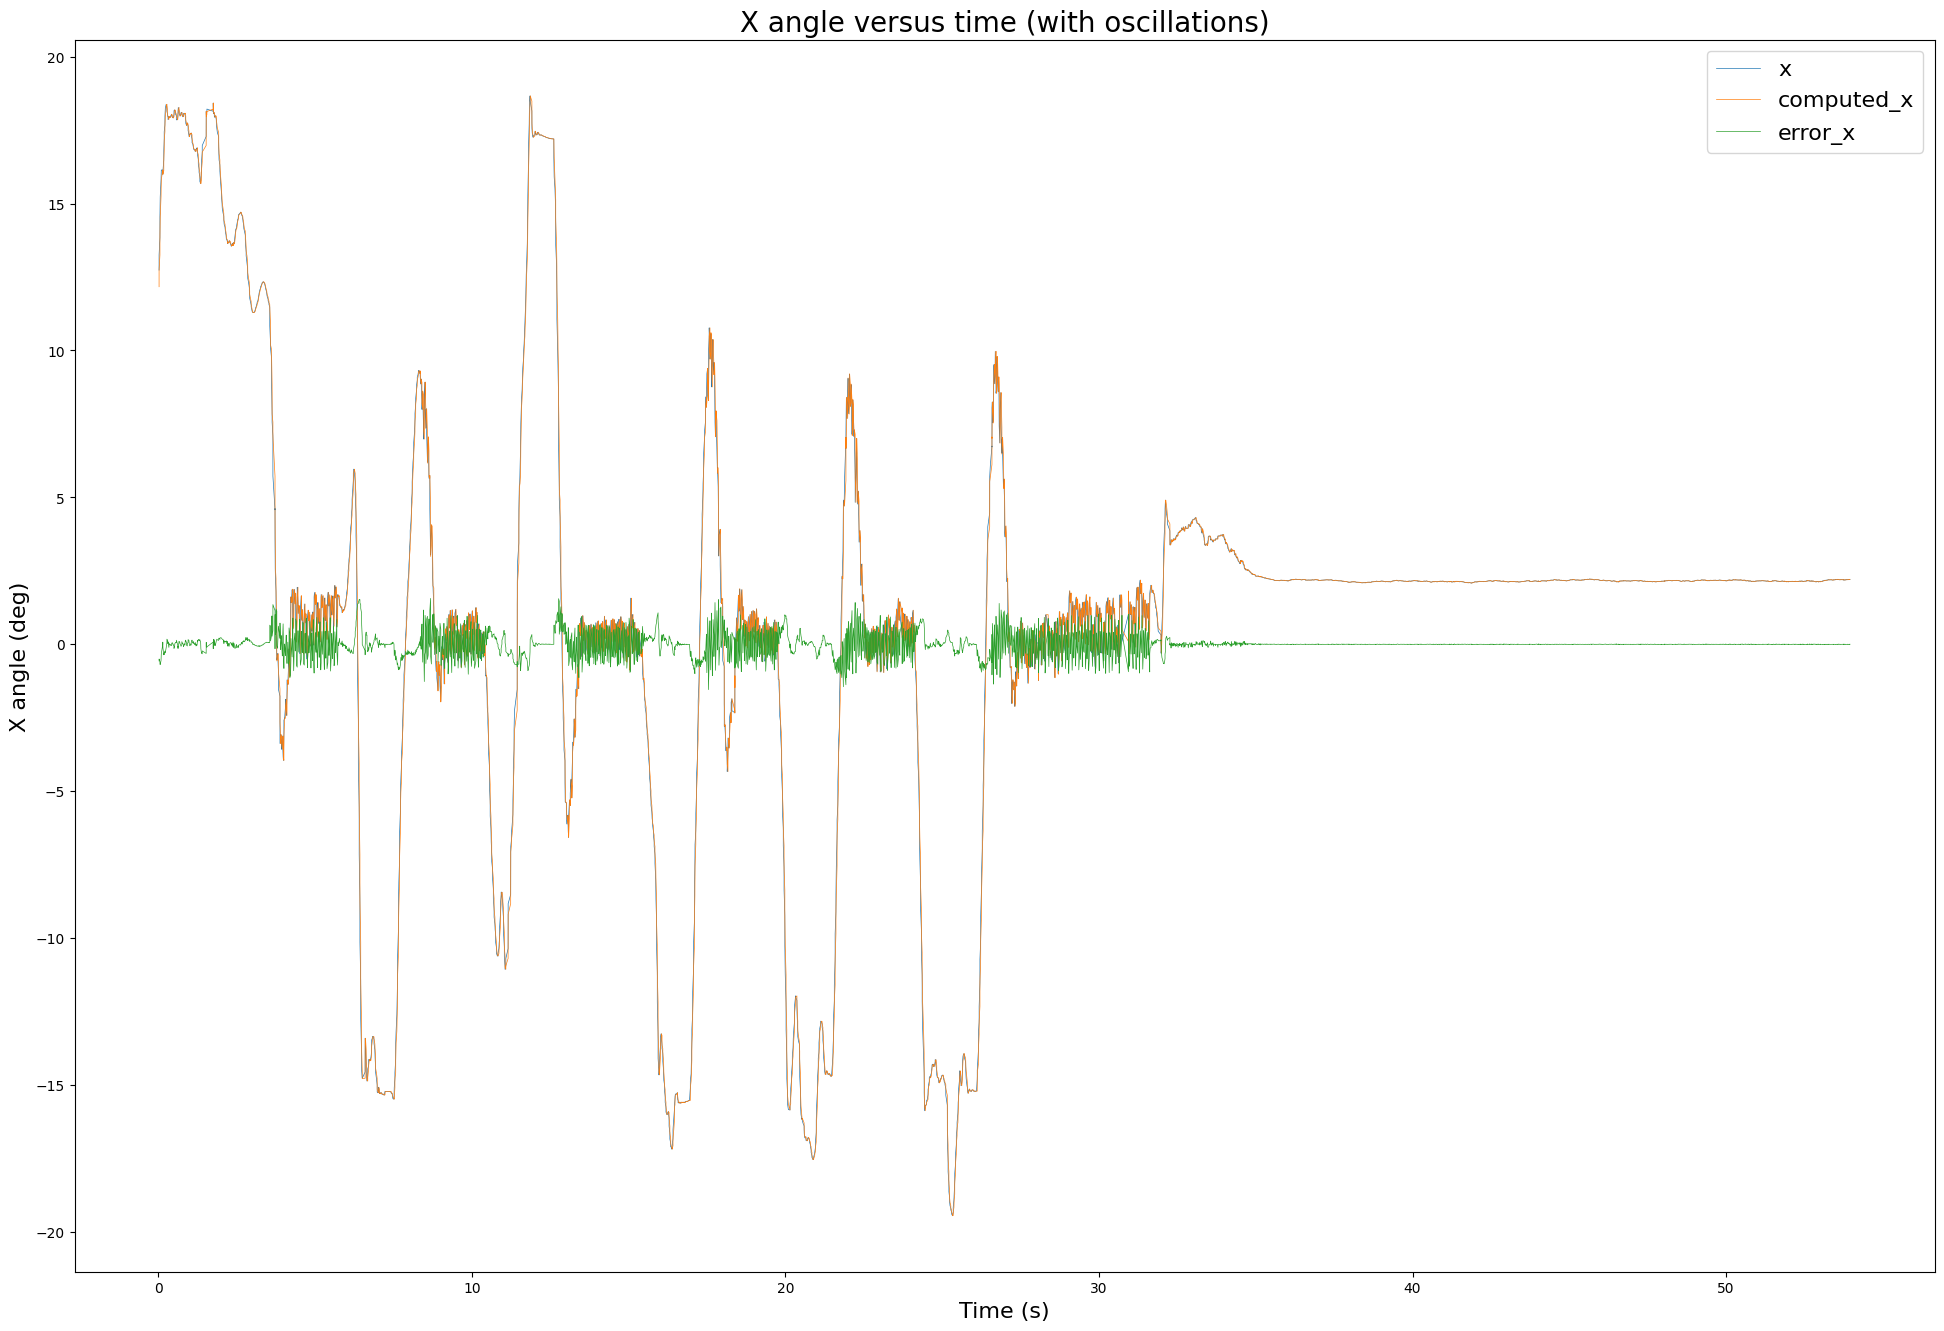

In [8]:
# plot x, computed_x, error_x
plt.figure(figsize=(24, 16))
plt.plot(df_zero["_time"], np.rad2deg(df_zero["x"]), label="x", linewidth=0.5)
plt.plot(df_zero["_time"], np.rad2deg(df_zero["computed_x"]), label="computed_x", linewidth=0.5)
plt.plot(df_zero["_time"], np.rad2deg(df_zero["error_x"]), label="error_x", linewidth=0.5)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("X angle (deg)", fontsize=16)
plt.title("X angle versus time (with oscillations)", fontsize=20)
plt.legend(fontsize=16)
plt.show()

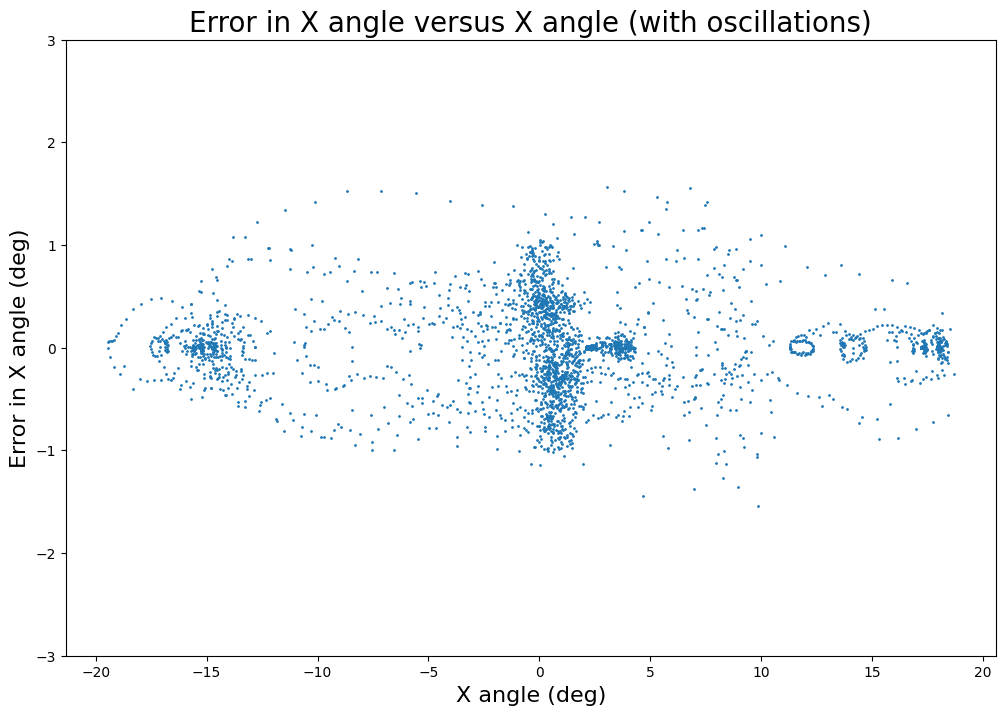

In [9]:
# plot scatter plot of error_x vs x
plt.figure(figsize=(12, 8))
plt.scatter(np.rad2deg(df_zero["x"]), np.rad2deg(df_zero["error_x"]), s=1)
plt.xlabel("X angle (deg)", fontsize=16)
plt.ylabel("Error in X angle (deg)", fontsize=16)
plt.title("Error in X angle versus X angle (with oscillations)", fontsize=20)
plt.ylim(-3, 3)
plt.show()

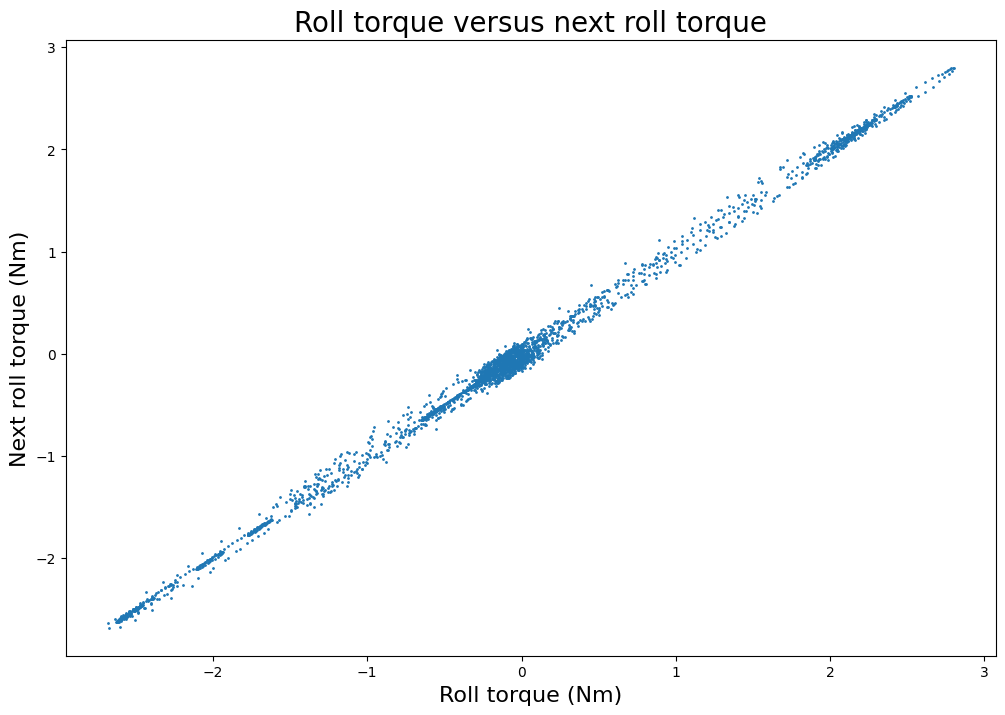

In [10]:
# Plot the roll torque vs next roll torque
roll_torques = df_zero["computed_roll_torque"]
plt.figure(figsize=(12, 8))
plt.scatter(roll_torques[:-1], roll_torques[1:], s=1)
plt.xlabel("Roll torque (Nm)", fontsize=16)
plt.ylabel("Next roll torque (Nm)", fontsize=16)
plt.title("Roll torque versus next roll torque", fontsize=20)
plt.show()